In [35]:
#load watermark extension
%load_ext watermark
#print watermark for notebook
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2018-04-22T09:36:03

CPython 2.7.14
IPython 5.4.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [2]:
#https://ipyton.org/ipython-docdex/config/extsions/autoreload.html
%reload_ext autoreload
%autoreload 2

#version information
%reload_ext version_information
%version_information Cython, matplotlib, numpy, pandas,  qutip, seaborn, scipy, sklearn, tqdm, version_information,


Software,Version
Python,2.7.14 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,5.4.1
OS,Darwin 17.3.0 x86_64 i386 64bit
Cython,0.26.1
matplotlib,2.1.0
numpy,1.13.3
pandas,0.20.3
qutip,The 'qutip' distribution was not found and is required by the application
seaborn,0.8.0
scipy,0.19.1


In [3]:
#standard packages
import pandas as pd
import numpy as np
#package for loop load time bar
from tqdm import tqdm
#statistical and machine learning packages
import scipy as sp
from sklearn.preprocessing import OneHotEncoder

#import scoring for machine learning
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score, auc,precision_recall_curve,classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm



#imports for preparing data for sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn. preprocessing import LabelEncoder

# packages for plotting 
import matplotlib.pyplot as plt
import seaborn as sns
#command to have graphs display in notebook
%matplotlib inline

In [4]:
#loading user order information
instacart_file=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/orders.csv')
df_orders=pd.DataFrame(instacart_file,)
df_orders.head(5)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
df_orders.nunique()

order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64

In [6]:
#capture the last order information for each user
g = df_orders.groupby('user_id')
data_p1=g.last()
data_p1['order_from_last']=1

In [7]:
#capture the second to last order information for each user
data_p2=g.nth(-2)
data_p2['order_from_last']=2

In [8]:
#capture the third to last order information for each user
data_p3=g.nth(-3)
data_p3['order_from_last']=3

In [9]:
#capture the fourth to last order information for each user
data_p4=g.nth(-4)
data_p4['order_from_last']=4

In an effort to save computation time, we will work first with a much smaller portion of the data. At the end of the notebook we will attempt to use as much as our system will allow.

## Concern: 
An issue with data wrangling is deciding how to preserve the time component of order history of the customer. I originally sought to segregate the data by breaking it into chunks by order: the test data is the customer's 2nd previous order, the training data the customer’s the 3rd and 4th previous orders together then splitting on it to cross validate. I then test on the 2nd to previous order as the test set. This was taking way to much time to run. I've adjust to a small test run below. The training data is only a small portion 150 cutomer orders from the 3rd previous order they made. The test set is the customers 2nd previous order. ( The most current previous order did not have lavels for all customers, hence, I choose to move to the customers 2nd previous order).

I feel like this should work on a much larger set. This data come from a kaggle competition so I feel like I shouldn't have to reduce as much as I am. Thoughts on how I'm approaching the data set up wrong? Insights in how to reduce run time to maximize data usage? 

# The small set test drive

In [10]:
#capture the third to last order information for each user
data_p3=data_p3.reset_index()
#sample 150 customers to make predictions for 
np.random.seed(42)
#reduce data size 
small=data_p3.sample(50)

In [11]:
#loading product reorder information
instacart_file2=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/order_products__prior.csv')
df_prod_orders=pd.DataFrame(instacart_file2,)
df_prod_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [12]:
#loading information for product names
instacart_products=pd.read_csv('/Users/luca/anaconda2/Springboard/Capstone Project 1/Data/products.csv')
df_prod=pd.DataFrame(instacart_products,)
df_prod.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
#add reorder information to training data
small_train=pd.merge(df_prod_orders,small, how= 'inner',left_on="order_id", right_on='order_id')
small_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last
0,32900,15040,1,0,206054,11.0,prior,2,18,30,3
1,32900,21043,2,0,206054,11.0,prior,2,18,30,3
2,32900,35504,3,1,206054,11.0,prior,2,18,30,3
3,32900,22491,4,1,206054,11.0,prior,2,18,30,3
4,59409,12212,1,0,105969,30.0,prior,3,20,4,3


In [14]:
#check to make sure NaN is taken care of 
small_train.isnull().any()

order_id                  False
product_id                False
add_to_cart_order         False
reordered                 False
user_id                   False
days_since_prior_order    False
eval_set                  False
order_dow                 False
order_hour_of_day         False
order_number              False
order_from_last           False
dtype: bool

In [15]:
#see how many products and users we have 
small_train.nunique()

order_id                   50
product_id                403
add_to_cart_order          25
reordered                   2
user_id                    50
days_since_prior_order     19
eval_set                    1
order_dow                   7
order_hour_of_day          15
order_number               23
order_from_last             1
dtype: int64

In [16]:
#data frame to ensure we have the same users in the test set
sample=pd.DataFrame(small_train['user_id'])

#capture the second to last order information for each user as a test set
data_p2=g.nth(-2)
data_p2['order_from_last']=2
data_p2=data_p2.reset_index()

#for test set add in reorder information
df_test=pd.merge(df_prod_orders,data_p2, how= 'inner',left_on="order_id", right_on='order_id')

#since we have train and test data broken apart by user previous order we can ensure we test only the users we trained for
small_test=pd.merge(df_test,sample, how= 'inner',left_on="user_id", right_on='user_id')
small_test.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last
0,81267,30776,1,1,53702,7.0,prior,6,13,63,2
1,81267,30776,1,1,53702,7.0,prior,6,13,63,2
2,81267,30776,1,1,53702,7.0,prior,6,13,63,2
3,81267,30776,1,1,53702,7.0,prior,6,13,63,2
4,81267,30776,1,1,53702,7.0,prior,6,13,63,2


In [17]:
#small_test=df_test.sample(150)
small_test.nunique()

order_id                   50
product_id                420
add_to_cart_order          25
reordered                   2
user_id                    50
days_since_prior_order     20
eval_set                    1
order_dow                   7
order_hour_of_day          15
order_number               23
order_from_last             1
dtype: int64

## Now we prep the feature columns to be in an appropriate format to utilize sklearn api 

In [18]:
#use pandas one hot encoder on training data's order_dow with added 'day' to column name
df_dow=pd.get_dummies(small_train['order_dow'],prefix='day')
#add reorder information to training data
train=pd.merge(small_train,df_dow, how= 'inner',left_index= True, right_index=True)
train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,32900,15040,1,0,206054,11.0,prior,2,18,30,3,0,0,1,0,0,0,0
1,32900,21043,2,0,206054,11.0,prior,2,18,30,3,0,0,1,0,0,0,0
2,32900,35504,3,1,206054,11.0,prior,2,18,30,3,0,0,1,0,0,0,0
3,32900,22491,4,1,206054,11.0,prior,2,18,30,3,0,0,1,0,0,0,0
4,59409,12212,1,0,105969,30.0,prior,3,20,4,3,0,0,0,1,0,0,0


In [19]:
#use pandas one hot encoder on test data's order_dow with added 'day' to column name 
df_dow=pd.get_dummies(small_test['order_dow'],prefix='day')
#add reorder information to training data
test=pd.merge(small_test,df_dow, how= 'inner',left_index= True, right_index=True)
test.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,order_from_last,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,81267,30776,1,1,53702,7.0,prior,6,13,63,2,0,0,0,0,0,0,1
1,81267,30776,1,1,53702,7.0,prior,6,13,63,2,0,0,0,0,0,0,1
2,81267,30776,1,1,53702,7.0,prior,6,13,63,2,0,0,0,0,0,0,1
3,81267,30776,1,1,53702,7.0,prior,6,13,63,2,0,0,0,0,0,0,1
4,81267,30776,1,1,53702,7.0,prior,6,13,63,2,0,0,0,0,0,0,1


In [20]:
train = train.reset_index()
test = test.reset_index()
train = train.set_index(['user_id','product_id']).sort_index()
test = test.set_index(['user_id','product_id']).sort_index()
test = test.drop_duplicates()
train = train.drop_duplicates()

In [21]:
#capture feature names and make a list
features=train[['add_to_cart_order', 'days_since_prior_order', 'order_hour_of_day', 'order_number', 'order_from_last', 'day_0','day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']]
feature_list = list(features.columns)
features=features.columns


#make a training set for sklearn features
xtrain = train[features]

#make a test set for sklearn features
xtest = test[features]

#convert target column into array for training set
ytrain = pd.factorize(small_train['reordered'])[0]

#convert target column into array for test set 
ytest = pd.factorize(small_test['reordered'])[0]


In [22]:
#see if the training data has the proper balance of reorders 
print ('% reorders in training set {:2f}'.format(float(ytrain.sum())/ytrain.size))
print ('% reorders in test set {:2f}'.format(float(ytest.sum())/ytest.size))

% reorders in training set 0.549474
% reorders in test set 0.456820


In [23]:
test.shape

(6195, 17)

In [24]:
train.shape

(475, 17)

# Question
Should I be concerned about the difference here in imbalance here? The EDA of all the data showed that reorders occured at 60% overall. Here in the training set, which is all the 3rd previous orders for customers the reorder rate  and the test set are also different. 

# Question:
What is to long for a runtime? This one, the randomized grid search, takes a few hours in the full set I would like to run.


## Now we use svm with rbf kernel on the data to make predictions for reorders

In [25]:
#to tune parameters 
clf=svm.SVC(kernel='rbf')

#fit classifier to validation set
clf.fit( xtrain , ytrain )

#get the prediction set for the validation 
preds_train_svm = clf.predict( xtrain )

#make some predictions
preds_svm = clf.predict( xtest )


#print the accuracy score for the training data
training_accuracy = clf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_svm )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_svm , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )

print (classification_report( ytest , preds_svm ))

Accuracy on training data: 0.77
Accuracy on test data: 0.43
F1 Score on train data: 0.8015
F1 Score on validation (train-test set) data: 0.4998
             precision    recall  f1-score   support

          0       0.46      0.28      0.35      3365
          1       0.42      0.62      0.50      2830

avg / total       0.44      0.43      0.42      6195



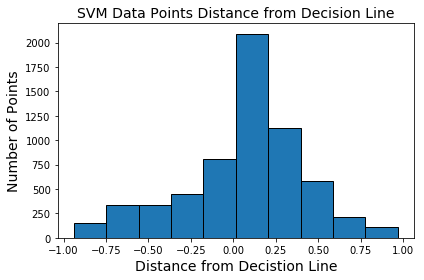

In [26]:
#can look at decision line 
clf.decision_function(xtest)

#plot the histogram of distance from boundry
plt.hist(clf.decision_function(xtest),edgecolor='k')
#add labels and title
plt.xlabel("Distance from Decistion Line", {'fontsize': 14})
plt.ylabel("Number of Points", {'fontsize': 14})

plt.title("SVM Data Points Distance from Decision Line", {'fontsize': 14})
#save figure for papers
plt.tight_layout()
plt.savefig('svm_distance.png')
#show figure in notebook
plt.show()

   classification report, which lists recovery statistics label by label
   
   # I should tune parametes here. Definitely overfitting
   
   SVM does not have predict_proba module. We can instead plot the distance from the decision line.
   Can plot a histogram od the decision function. Need to work on making plot of the decision function on the plane. 
   See if I can plot the support vectors as well.


In [27]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [28]:
#look at confusion matrix
confusion_matrix( ytest , preds_svm )

array([[ 927, 2438],
       [1075, 1755]])

## Now look at model measurements: ROC Curve, Precision-Recall Curves and AUC 

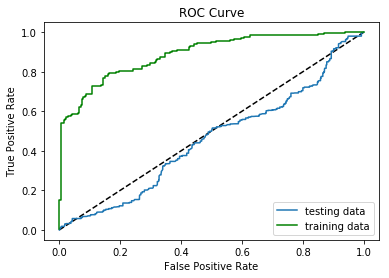

In [29]:
#predict the probabilities for each observation in training set
#pred_train_prob_svm = clf.decision_function(xtrain)[:,1]

#predict the probabilities for each observation in test set
#pred_prob_svm = clf.predict_proba(xtest)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr , xtpr , xthres = roc_curve(ytrain , clf.decision_function(xtrain) )

#get false positive rate, true positive rate, and thresholds for test data
fpr , tpr , thres = roc_curve( ytest , clf.decision_function(xtest))

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot(fpr,tpr,label='testing data')
plt.plot(xfpr,xtpr, 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

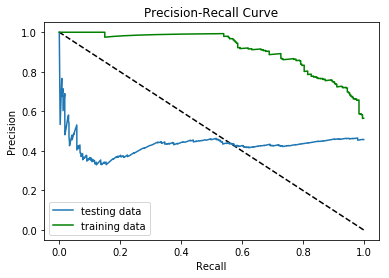

In [30]:
xprec_score,xrecall_score,xthresholds=precision_recall_curve( ytrain , clf.decision_function(xtrain) )

prec_score,recall_score,thresholds=precision_recall_curve( ytest , clf.decision_function(xtest))

plt.plot([1,0],[0,1],'k--')
plt.plot(recall_score,prec_score,label='testing data')
plt.plot(xrecall_score,xprec_score,'g-',label='training data')
#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

In [31]:
roc_auc_score(ytest , clf.decision_function(xtest))

0.45495965010842232

In [32]:
% time cv_auc_scores=cross_val_score(clf, xtrain , ytrain, cv=5, scoring='roc_auc')
print(cv_auc_scores)

CPU times: user 64.6 ms, sys: 1.85 ms, total: 66.4 ms
Wall time: 67.8 ms
[ 0.52523036  0.34615385  0.36270125  0.519678    0.3956044 ]


#know lets tune the parameters for the svm 
from sklearn.model_selection import StratifiedShuffleSplit

# Sklearn recommends for an initial search, a logarithmic grid with basis 10 is often helpful. Using a basis 
# of 2, a finer tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
#param_grid = dict(gamma=gamma_range, C=C_range)

parameters = {'C': C_range , 'gamma' : gamma_range }
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
            

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(clf,  param_distributions= parameters ,cv= cv, refit= True, n_jobs= 2, random_state= 42, scoring='f1')

#fit grid search on random forest over grid
%time rs.fit( xtrain ,  ytrain )

## The above was with default settings lets tune the model and see if we can imporve.

In [33]:
#know lets tune the parameters for the svm 
from sklearn.model_selection import StratifiedShuffleSplit

# Sklearn recommends for an initial search, a logarithmic grid with basis 10 is often helpful. Using a basis 
# of 2, a finer tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 5)
gamma_range = np.logspace(-9, 3, 5)
#param_grid = dict(gamma=gamma_range, C=C_range)

parameters = {'C': C_range , 'gamma' : gamma_range }
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
            

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(clf,  param_distributions= parameters ,cv= cv, refit= True, n_jobs= 2, random_state= 42, scoring='f1')

#fit grid search on random forest over grid
%time rs.fit( xtrain ,  ytrain )

CPU times: user 1.84 s, sys: 348 ms, total: 2.19 s
Wall time: 1h 51min 19s


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'C': array([  1.00000e-02,   1.00000e+01,   1.00000e+04,   1.00000e+07,
         1.00000e+10]), 'gamma': array([  1.00000e-09,   1.00000e-06,   1.00000e-03,   1.00000e+00,
         1.00000e+03])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

# Question:
Does my approach at cross-validation voilate any principles? Do you see anything wrong here? Can I do it better?

In [34]:
#save best parameters to use on test set
best_c = rs.best_params_['C'] 
best_gamma=rs.best_params_['gamma'] 

#print best parameter results
print("the best regulization C is {} and the best gamma, radius of influence of support vectors is {}".format(best_c,best_gamma))
print("the best f1 score with these is {}".format(rs.best_score_))

the best regulization C is 0.01 and the best gamma, radius of influence of support vectors is 1e-09
the best f1 score with these is 0.707482993197


Note that the C value is at the edge of our range. Lets look at the learning curve to we should continue to look for a better C. We will also check the learning curve on the gamma. 

/Users/luca/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/luca/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


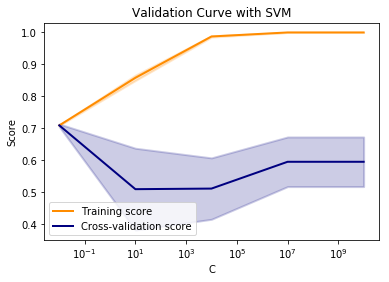

In [36]:
from sklearn.learning_curve import validation_curve
#degree = np.arange(0, 21)
param_range=C_range
train_scores, test_scores = validation_curve( clf , xtrain, ytrain, param_name="C", param_range= param_range , cv=10, scoring="f1", n_jobs=2 )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("C")
plt.ylabel("Score")
#plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

We see that after C gets above 100 the computational time is not benefiting the score. Hence we will move the upper range to 100 and the lower bound to 10^-1.

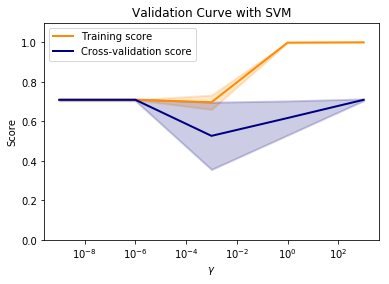

In [38]:
from sklearn.learning_curve import validation_curve
#degree = np.arange(0, 21)
param_range=gamma_range
train_scores, test_scores = validation_curve( clf , xtrain, ytrain, param_name="gamma", param_range= gamma_range , cv=10, scoring="f1", n_jobs=2 )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Looking at the gamma learning curve we begin to overfit at around 10^-3 and no improvement for gamma  below 10^-5. Lets retune with these ranges. 

In [39]:
#know lets tune the parameters for the svm 
from sklearn.model_selection import StratifiedShuffleSplit

# Sklearn recommends for an initial search, a logarithmic grid with basis 10 is often helpful. Using a basis 
# of 2, a finer tuning can be achieved but at a much higher cost.

C_range = np.logspace(-1, 2, 13)
gamma_range = np.logspace(-5, -3, 13)
#param_grid = dict(gamma=gamma_range, C=C_range)

parameters = {'C': C_range , 'gamma' : gamma_range }
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
            

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(clf,  param_distributions= parameters ,cv= cv, refit= True, n_jobs= 2, random_state= 42, scoring='f1')

#fit grid search on random forest over grid
%time rs.fit( xtrain ,  ytrain )

CPU times: user 210 ms, sys: 34.1 ms, total: 244 ms
Wall time: 728 ms


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
          error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'C': array([   0.1    ,    0.17783,    0.31623,    0.56234,    1.     ,
          1.77828,    3.16228,    5.62341,   10.     ,   17.78279,
         31.62278,   56.23413,  100.     ]), 'gamma': array([  1.00000e-05,   1.46780e-05,   2.15443e-05,   3.16228e-05,
         4.64159e-05,   6.81292e-05,   1.00000e-04,   1.46780e-04,
         2.15443e-04,   3.16228e-04,   4.64159e-04,   6.81292e-04,
         1.00000e-03])},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='wa

In [40]:
#save best parameters to use on test set
best_c = rs.best_params_['C'] 
best_gamma=rs.best_params_['gamma'] 

#print best parameter results
print("the best regulization C is {} and the best gamma, radius of influence of support vectors is {}".format(best_c,best_gamma))
print("the best f1 score with these is {}".format(rs.best_score_))

the best regulization C is 0.316227766017 and the best gamma, radius of influence of support vectors is 4.64158883361e-05
the best f1 score with these is 0.707482993197


In [41]:
#to tune parameters 
clf_svm=svm.SVC( kernel='rbf', C= best_c , gamma= best_gamma )

#fit classifier to validation set
clf_svm.fit( xtrain , ytrain )

#get the prediction set for the validation 
preds_train_svm = clf_svm.predict( xtrain )

#make some predictions
preds_svm = clf_svm.predict( xtest )


#print the accuracy score for the training data
training_accuracy = clf_svm.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_svm.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_svm )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_svm , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )

print (classification_report( ytest , preds_svm ))

Accuracy on training data: 0.55
Accuracy on test data: 0.46
F1 Score on train data: 0.7092
F1 Score on validation (train-test set) data: 0.6271
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3365
          1       0.46      1.00      0.63      2830

avg / total       0.21      0.46      0.29      6195



/Users/luca/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


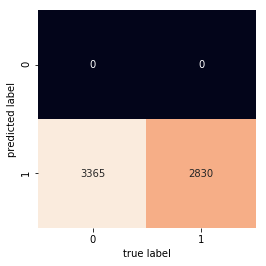

In [42]:

mat = confusion_matrix( ytest , preds_svm  )
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [43]:
confusion_matrix( ytest , preds_svm  )

array([[   0, 3365],
       [   0, 2830]])

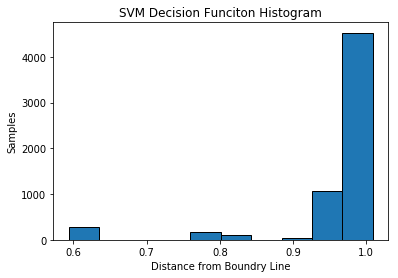

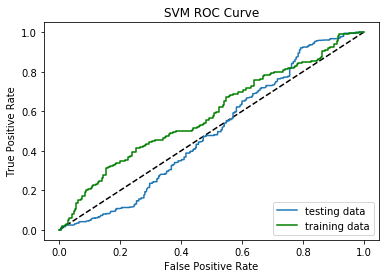

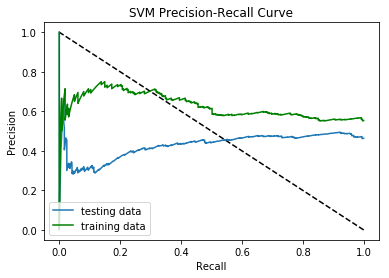

The Area Under the Curve foe the Support Vector Machine is 0.50


In [44]:
#can look at decision line 
clf_svm.decision_function(xtest)

#plot the histogram of distance from boundry
plt.hist(clf_svm.decision_function(xtest),edgecolor='k' )
#add labels
plt.xlabel("Distance from Boundry Line")
plt.ylabel("Samples")
plt.title('SVM Decision Funciton Histogram')
plt.legend(loc=3)
plt.show()


#plot ROC curve 
#get false positive rate, true positive rate, and thresholds for training data
xfpr_svm , xtpr_svm , xthres_svm = roc_curve(ytrain , clf_svm.decision_function(xtrain) )

#get false positive rate, true positive rate, and thresholds for test data
fpr_svm , tpr_svm , thres_svm = roc_curve( ytest , clf_svm.decision_function(xtest) )

#plot base line at .5 probability
plt.plot( [0,1] , [0,1] , 'k--' )
#plot model train and test
plt.plot( fpr_svm , tpr_svm , label= 'testing data')
plt.plot( xfpr_svm , xtpr_svm , 'g-', label= 'training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('SVM ROC Curve')
plt.legend(loc=4)
plt.show()

#plot the precision-recall curve for tuned model
#get values for training set
xprec_score_svm , xrecall_score_svm ,xthresholds_svm =precision_recall_curve( ytrain , clf_svm.decision_function(xtrain) )
#get values for test set
prec_score_svm , recall_score_svm , thresholds_svm = precision_recall_curve( ytest , clf_svm.decision_function(xtest))

#plot lines
plt.plot( [1,0] , [0,1] , 'k--' )
plt.plot( recall_score_svm , prec_score_svm , label= 'testing data')
plt.plot( xrecall_score_svm , xprec_score_svm , 'g-' , label= 'training data')
#add labels
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('SVM Precision-Recall Curve')
plt.legend(loc=3)
plt.show()
         
svm_test_auc=roc_auc_score(ytest , clf_svm.decision_function(xtest))  
print("The Area Under the Curve foe the Support Vector Machine is {:.2f}".format(svm_test_auc))

We see, looking closer at the histogram, the distance each point lays from the separator. Most points are near the boundry indictating that reorders and non-reorders look very similiar. This is an indication that we might need to look for more features to differentiate the classes. In an apple an orange example, we could be only looking at the roundness of the fruit instead of the color. We would hope to find some feature that separates the classes a bit better than this.  

## Improvements to make later: add one hot encode to hod column, scale/normalize all features, cross validate the auc scores, plot decision boundry on plane, add feature engineering...

# Next Random Forest 

Straight out of the box with the default settings. 

In [45]:
#create classifier from best parameters out of grid search
clf_rf=RandomForestClassifier()
#fit classifier to validation set
clf_rf.fit(xtrain,ytrain)

#get the prediction set for the validation 
preds_train_rf = clf_rf.predict(xtrain)

#make some predictions
preds_rf = clf_rf.predict(xtest)


#print the accuracy score for the training data
training_accuracy = clf_rf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_rf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_rf )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_rf , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}\n".format( fscore ) )


print ( classification_report ( ytest , preds_rf ))

Accuracy on training data: 0.95
Accuracy on test data: 0.49
F1 Score on train data: 0.9563
F1 Score on validation (train-test set) data: 0.4250

             precision    recall  f1-score   support

          0       0.53      0.55      0.54      3365
          1       0.44      0.41      0.42      2830

avg / total       0.49      0.49      0.49      6195



In [46]:
#look at confusion matrix
confusion_matrix( ytest , preds_rf )

array([[1844, 1521],
       [1656, 1174]])

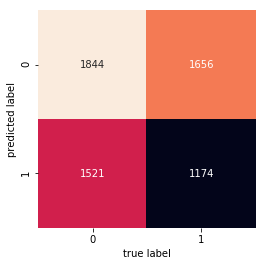

In [47]:

mat = confusion_matrix( ytest , preds_rf )
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Not good looks like we are overfitting again. Once more we will look at tuning the parameters. First through lets finish the analysis here in order to have something to compare the next tuning against.

In [48]:
#Capture model feature importance 
importances=clf_rf.feature_importances_

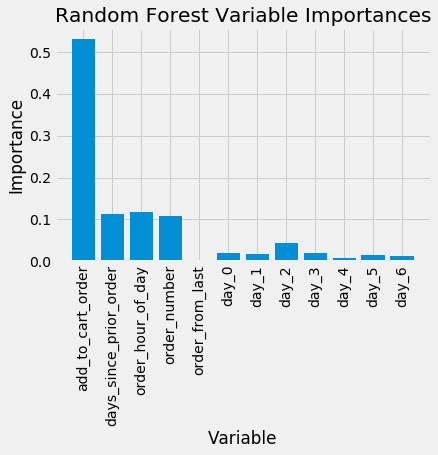

In [49]:
#plot the variable importances
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Random Forest Variable Importances');

#save figure
plt.savefig('feature_importance.png')
#show figure in notebook
plt.show()

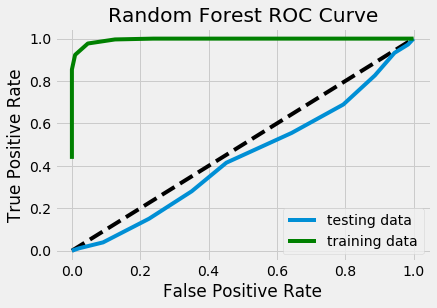

In [50]:
#predict the probabilities for each observation in training set
pred_train_prob_rf = clf_rf.predict_proba(xtrain)[:,1]

#predict the probabilities for each observation in test set
pred_prob_rf = clf_rf.predict_proba(xtest)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr_rf , xtpr_rf , xthres_rf = roc_curve(ytrain , pred_train_prob_rf )

#get false positive rate, true positive rate, and thresholds for test data
fpr_rf , tpr_rf , thres_rf = roc_curve( ytest , pred_prob_rf )

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot( fpr_rf , tpr_rf ,label='testing data')
plt.plot( xfpr_rf , xtpr_rf , 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Random Forest ROC Curve')
plt.legend(loc=4)
plt.show()

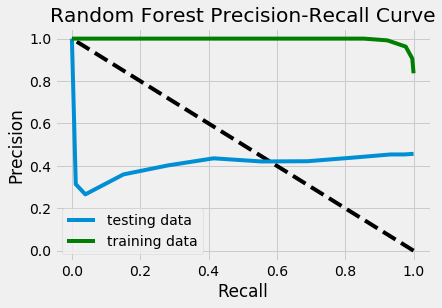

In [51]:

xprec_score_rf , xrecall_score_rf ,xthresholds_rf = precision_recall_curve( ytrain , pred_train_prob_rf )

prec_score_rf , recall_score_rf ,thresholds_rf = precision_recall_curve( ytest , pred_prob_rf)

plt.plot([1,0],[0,1],'k--')
plt.plot( recall_score_rf , prec_score_rf ,label='testing data')
plt.plot( xrecall_score_rf , xprec_score_rf ,'g-',label='training data')

#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Random Forest Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

In [52]:
rf_test_auc=roc_auc_score(ytest , pred_prob_rf)
print("The Area Under the Curve foe the Randam Forest is {:.2f}".format(rf_test_auc))

The Area Under the Curve foe the Randam Forest is 0.44


In [53]:
# cross validate on scoring of auc (20 min to run) 
cv_auc_scores=cross_val_score(clf_rf, xtrain , ytrain , cv=5, scoring='roc_auc')
print(cv_auc_scores)

[ 0.55660377  0.33050089  0.51900716  0.36918605  0.45695971]


# The tuning for the Random Forest parameters

We are overfitting. So lets limit how much the model gets to split down the tree. We do this with max_depth. It should prevent us from fitting to every data point. We will also look at limiting the number of samples to be considered a leaf node. We overfit if each data point is a leaf. 

In [54]:
#know lets tune the parameters for the random forest

#set parametets to tune in Random Grid Search (# depth of trees and # min samples per leaf)
parameters={'max_depth':xrange(1,14),'min_samples_leaf':[5,10,20,30,40,50,100]}

#create an instance of the random forest classifier
rf=RandomForestClassifier()

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(rf, param_distributions=parameters,cv=5,refit=True,n_jobs=2,random_state=42,scoring='f1')

#fit grid search on random forest over grid
rs.fit( xtrain ,  ytrain )

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'max_depth': xrange(1, 14), 'min_samples_leaf': [5, 10, 20, 30, 40, 50, 100]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [55]:
#save best parameters to use on test set
best_depth = rs.best_params_['max_depth'] 
best_leaf=rs.best_params_['min_samples_leaf'] 

#print best parameter results
print("the best depth of trees is {} with a minimum number of samples per leaf of {}".format( best_depth , best_leaf ))
print("the best f1 score with these is {}".format(rs.best_score_))

the best depth of trees is 8 with a minimum number of samples per leaf of 100
the best f1 score with these is 0.709235493019


# The learning curve for the Random Forest parameters

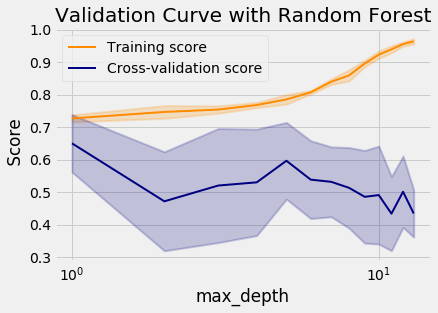

In [56]:
#save the range for the Random Forest n_estimators parameter to a variable
param_range= parameters["max_depth"]
#get learning scores
train_scores, test_scores = validation_curve( clf_rf, xtrain, ytrain, param_name="max_depth", param_range= param_range , cv=10, scoring="f1", n_jobs=2 )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel("max_depth")
plt.ylabel(" Score")
#plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

The learning highlights that the max_depth cross_validation score stabilizes at around 5. We see that going deeper starts to overfit to the training data as the yellow line departs form the purple. 

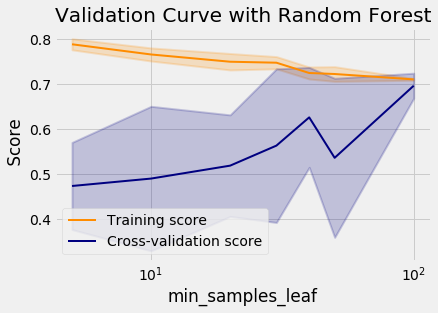

In [57]:
#save the range for the Random Forest n_estimators parameter to a variable
param_range= parameters['min_samples_leaf']
#get learning scores
train_scores, test_scores = validation_curve( clf_rf, xtrain, ytrain, param_name='min_samples_leaf', param_range= param_range , cv=10, scoring="f1", n_jobs=2 )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel('min_samples_leaf')
plt.ylabel(" Score")

lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

As we would expect the more samples in the leaf the less overfit our model is. However, after around 20 we see that start to affect the cross-validation score begins to decrease with the training score. 

In [58]:
#create classifier from best parameters out of grid search
clf_rf=rs.best_estimator_
#fit classifier to validation set
clf_rf.fit(xtrain,ytrain)

#get the prediction set for the validation 
preds_train_rf = clf_rf.predict(xtrain)

#make some predictions
preds_rf = clf_rf.predict(xtest)


#print the accuracy score for the training data
training_accuracy = clf_rf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_rf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_rf )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_rf , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )


print ( classification_report ( ytest , preds_rf ))

Accuracy on training data: 0.58
Accuracy on test data: 0.44
F1 Score on train data: 0.7093
F1 Score on validation (train-test set) data: 0.5460
             precision    recall  f1-score   support

          0       0.45      0.18      0.25      3365
          1       0.43      0.74      0.55      2830

avg / total       0.44      0.44      0.39      6195



In [59]:
#look at confusion matrix
confusion_matrix( ytest , preds_rf )

array([[ 594, 2771],
       [ 727, 2103]])

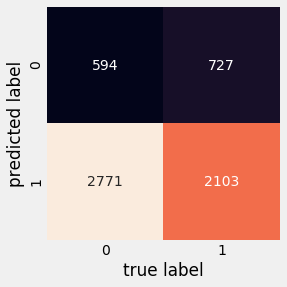

In [60]:
mat = confusion_matrix( ytest , preds_rf )
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Better, we have reduce some of the overfit. Tuning two more parameters we will see if we can do better. Thins time we tune number of trees in the forest and the number of features each tree looks at. We leave the best depth and best min_samples_leaf.  

In [61]:
#know lets tune the parameters for the random forest

#set parametets to tune in Random Grid Search (# trees in forest and # of features per tree)
parameters={'n_estimators':range(1,40),'max_features':['auto',1,2,3,4,5], 'max_depth': [ rs.best_params_['max_depth'] ] , 'min_samples_leaf' : [rs.best_params_['min_samples_leaf'] ] }

#create an instance of the random forest classifier
rf=RandomForestClassifier()

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(rf, param_distributions=parameters,cv=5,refit=True,n_jobs=2,random_state=42,scoring='f1')

#fit grid search on random forest over grid
rs.fit( xtrain ,  ytrain )

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 'max_features': ['auto', 1, 2, 3, 4, 5], 'max_depth': [8], 'min_samples_leaf': [100]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [62]:
#save best parameters to use on test set
best_n = rs.best_params_['n_estimators'] 
best_features=rs.best_params_['max_features'] 

#print best parameter results
print("the best number of trees is {} with a maximum number of features of {}".format(best_n,best_features))
print("the best f1 score with these is {}".format(rs.best_score_))

the best number of trees is 11 with a maximum number of features of 3
the best f1 score with these is 0.709614908729


In [63]:
rs.best_params_

{'max_depth': 8,
 'max_features': 3,
 'min_samples_leaf': 100,
 'n_estimators': 11}

In [64]:
#create classifier from best parameters out of grid search
clf_rf=rs.best_estimator_
#fit classifier to validation set
clf_rf.fit(xtrain,ytrain)

#get the prediction set for the validation 
preds_train_rf = clf_rf.predict(xtrain)

#make some predictions
preds_rf = clf_rf.predict(xtest)


#print the accuracy score for the training data
training_accuracy = clf_rf.score( xtrain , ytrain )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_rf.score(xtest , ytest)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( ytrain , preds_train_rf )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( ytest , preds_rf , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )


print ( classification_report ( ytest , preds_rf ))

Accuracy on training data: 0.55
Accuracy on test data: 0.46
F1 Score on train data: 0.7092
F1 Score on validation (train-test set) data: 0.6271
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      3365
          1       0.46      1.00      0.63      2830

avg / total       0.21      0.46      0.29      6195



We did not achieve much improvement. The validation f1 score, our metric, did improve slightly. In the future we could try tuning these parameters more to improve.

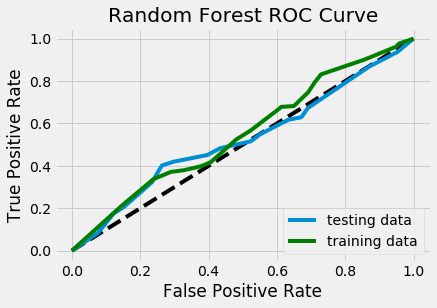

In [65]:
#predict the probabilities for each observation in training set
pred_train_prob_rf = clf_rf.predict_proba(xtrain)[:,1]

#predict the probabilities for each observation in test set
pred_prob_rf = clf_rf.predict_proba(xtest)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr_rf , xtpr_rf , xthres_rf = roc_curve(ytrain , pred_train_prob_rf )

#get false positive rate, true positive rate, and thresholds for test data
fpr_rf , tpr_rf , thres_rf = roc_curve( ytest , pred_prob_rf )

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot( fpr_rf , tpr_rf ,label='testing data')
plt.plot( xfpr_rf , xtpr_rf , 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Random Forest ROC Curve')
plt.legend(loc=4)
plt.show()

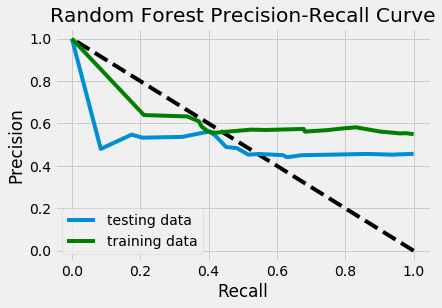

In [66]:

xprec_score_rf , xrecall_score_rf ,xthresholds_rf = precision_recall_curve( ytrain , pred_train_prob_rf )

prec_score_rf , recall_score_rf ,thresholds_rf = precision_recall_curve( ytest , pred_prob_rf)

plt.plot([1,0],[0,1],'k--')
plt.plot( recall_score_rf , prec_score_rf ,label='testing data')
plt.plot( xrecall_score_rf , xprec_score_rf ,'g-',label='training data')

#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Random Forest Precision-Recall Curve')
plt.legend(loc=3)
plt.show()

In [67]:
rf_test_auc=roc_auc_score(ytest , pred_prob_rf)
print("The Area Under the Curve foe the Randam Forest is {:.2f}".format(rf_test_auc))

The Area Under the Curve foe the Randam Forest is 0.52


In [68]:
# cross validate on scoring of auc (20 min to run) 
cv_auc_scores=cross_val_score(clf_rf, xtrain , ytrain , cv=5, scoring='roc_auc')
print(cv_auc_scores)

[ 0.41904344  0.32938283  0.47115385  0.59145796  0.60691392]


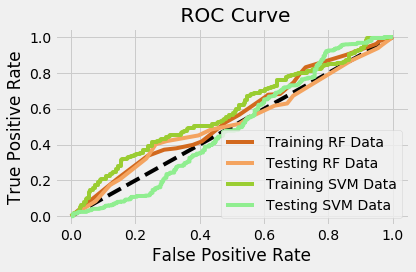

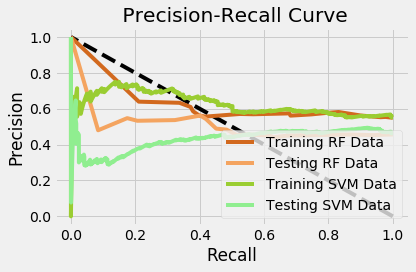

In [69]:
#Plot both models together

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test for each model
plt.plot(xfpr_rf , xtpr_rf , c='chocolate', label='Training RF Data')
plt.plot(fpr_rf , tpr_rf , c='sandybrown', label='Testing RF Data')
plt.plot(xfpr_svm , xtpr_svm , c='yellowgreen' , label='Training SVM Data')
plt.plot(fpr_svm , tpr_svm ,c='lightgreen' , label='Testing SVM Data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(' ROC Curve')
plt.legend(loc=4)
#save figure for papers
plt.tight_layout()
plt.savefig('models_roc.png')
#show figure in notebook
plt.show()

#plot both Precision_Recall models on one
plt.plot([1,0],[0,1],'k--')
plt.plot(xrecall_score_rf , xprec_score_rf, c='chocolate',label='Training RF Data')
plt.plot(recall_score_rf , prec_score_rf,  c='sandybrown' ,label='Testing RF Data')

plt.plot( xrecall_score_svm , xprec_score_svm , c='yellowgreen' , label= 'Training SVM Data')
plt.plot( recall_score_svm , prec_score_svm , c='lightgreen', label= 'Testing SVM Data')

#plt.plot(xfpr,xtpr, 'g-',label='training data')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(' Precision-Recall Curve')
plt.legend(loc=4)
#save figure for papers
plt.tight_layout()
plt.savefig('models_PR-curve.png')
#show figure in notebook
plt.show()

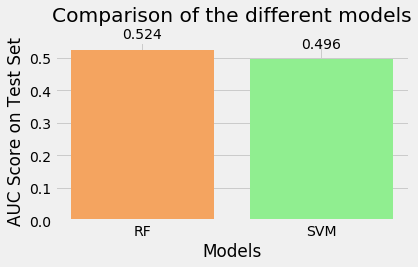

In [70]:
#dictionary to hold auc scores form tuned models
plot_model={'RF':rf_test_auc ,'SVM':svm_test_auc}

#make an instance for plotting figures
fig, ax = plt.subplots()

#set parameters for bar chart
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

#plot bar for chart
rects1 = ax.bar(ind, plot_model.values(), color= ['sandybrown','lightgreen'])

#define a function to add bar chart labels to bars (straight from matplotlib docs)
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*float(height),'%.3f' % float(height),ha='center', va='bottom')
        
#call function to add bar char labels to bars
autolabel(rects1)


# add some text for axes ticks
ax.set_xticks(ind)
ax.set_xticklabels(plot_model.keys())

ax.legend()

#add label and title
plt.title("Comparison of the different models",y = 1.08)
plt.xlabel("Models")
plt.ylabel("AUC Score on Test Set")
#save figure for papers
plt.tight_layout()
plt.savefig('models_auc.png')
#show figure in notebook
plt.show()


In [71]:
small_test.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194],
           dtype='int64', length=6195)

In [72]:
small_test.set_index(['user_id' , 'product_id'])

order_id  add_to_cart_order  reordered  \
user_id product_id                                           
53702   30776          81267                  1          1   
        30776          81267                  1          1   
        30776          81267                  1          1   
        30776          81267                  1          1   
        30776          81267                  1          1   
        30776          81267                  1          1   
        30776          81267                  1          1   
        30776          81267                  1          1   
        30776          81267                  1          1   
        1463           81267                  2          1   
        1463           81267                  2          1   
        1463           81267                  2          1   
        1463           81267                  2          1   
        1463           81267                  2          1   
        1463           81267                  2          1   
        1463           81267                  2          1   
        1463           81267                  2          1   
        1463           81267                  2          1   
        34943          81267                  3          1   
        34943          81267                  3          1   
        34943          81267                  3          1   
        34943          81267                  3          1   
        34943          81267                  3          1   
        34943          81267                  3          1   
        34943          81267                  3          1   
        34943          81267                  3          1   
        34943          81267                  3          1   
        3952           81267                  4          1   
        3952           81267                  4          1   
        3952           81267                  4          1   
...                      ...                ...        ...   
203190  40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        40706        3369864                  5          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   
        34969        3369864                  6          1   

                    days_since_prior_order eval_set  order_dow  \
user_id product_id                             

In [37]:
34+4

38